# Web Scraping

Lots of great data is available online, but available through inconveniently formatted web pages. When this is the case, sometimes you can simply copy and paste the data into a .csv file and go on with your life. But if there are many records to parse and combine into a dataset, that might be impossible. Can we automate the collection of data from online sources?

This is called web scraping. Broadly speaking: Web scraping is legal, but what you plan to do with the results of your scraping might not be. In general, most sites do not want you to scrape them at this point, but there is not really a way to stop you if you are sufficiently motivated. Be careful to use server resources respectfully (not too many requests per unit time), think seriously about privacy concerns, and be careful who you share your work with and how it is used.

We'll be scraping data about used cars in Charlottesville from Craigslist, particularly this page: https://charlottesville.craigslist.org/search/cta?purveyor=owner#search=1~gallery~0~0 

We'll use the `requests` package to get web pages off the Internet and into Python. Again, we'll use a header with a user-agent that masks our true identity so that we're not rejected by the server. This particular url points to the car listings for Craigslist in Charlottesville. To use requests, you pass a `url` for the page you want and a `header` that controls how you appear to the server to `requests.get`:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import requests # Page requests

header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0'} # How we wish to appear to CL
url = 'https://charlottesville.craigslist.org/search/cta?purveyor=owner#search=1~gallery~0~0' # The page we want to scrape
raw = requests.get(url,headers=header) # Get page

Now that we have that particular page available locally, we want to **parse** it and get results from it. To do that, we can use a package called `beautifulSoup` or `bs4`.

What does `beautifulSoup` do for us? Let's go to the web page of interest. You probably see something like this:

![Listings](./src/craigslist.png "Craigslist")

But if you "view page source" -- which is CTRL+U -- in Chrome, you see what the computer sees:

![Listings](./src/craigslist_source.png "Craigslist")

Since your web browser needs lots of instructions about how to render the text, pictures, and other content on your web page, there are a lot of clues about where the data live and how to extricate them from a page. These clues are called **tags**. If you wander the source for the search page on cars, you see a particular `class = "cl-static-search-result"` term appear attached to each listing:

![Listings](./src/listing.png "Craigslist")

This structure can be exploited to search the page for information. This kind of detective work -- looking at the page source, finding the interesting tags, and then searching the page with `beautifulSoup` -- is the basic job of web scraping.

What I do is look at the rendered page, find the text I want and copy it, then search for that text in the HTML code that the computer sees. When I find the text I want, I look for the tag nearby. Here, it's `cl-static-search-result`: That's what I'll want beautifulSoup to search for.

The following code chunk takes the raw content from `requests` and turns it into a beautifulSoup object, which can search the page and return results for us:

In [2]:
from bs4 import BeautifulSoup as soup # HTML parser
bsObj = soup(raw.content,'html.parser') # Parse the html
listings = bsObj.find_all(class_="cl-static-search-result") # Find all listings of the kind we want

Why is the argument `class_` and not just `class`? The word `class` is a reserved keyword for Python, and cannot be used by anyone else, similar to `True` and `False`. But since we want the `class = "cl-static-search-result"` terms, we need to use the `class_` argument to the `.find_all` method.

The `.find_all` function dredges the entire page and finds all the instances of `class = "cl-static-search-result"`, resulting in a list of entries. We can then parse the entries.

Parsing the entries can be a challenge! We have to go back to what a listing looks like, and look at the tags within the listing. They're typically `div` tags with a `class` like price or location. You then have to experiment a bit with `.find` and the HTML to make sure you're getting the information you want. For each listing, the `.find` method to search within the listing record for specific information, but it's typically still wrapped in the tag. To get the real information we want, we can then use `.get_text()`. I end up using a code chunk to experiment and play with a record to make sure I'm getting as close to what I want as possible.

In the code below, two more things happen. You don't need to do them in your work, but they're helpful to know about.

First, I would like to get the brand of the car from the post title, if possible. To do this, I split the title into words using `title.split()`, and then I use a list comprehension to look over every word in the title and check whether it appears in the `brands` list.

Second, I would like to get the year the car was built, if possible, so I can determine the vehicle's age. To do this, I use a thing called **regular expressions** that provides a language for expressing patterns. Do I remember how to do this off the top of my head? No, I read a few pages in a book and looked on StackOverflow for answers. Roughly, in order to express the idea "any year starting with 20xx," you can write `20[0-9][0-9]`, and for "any year starting with 19xx," you can write `19[0-9][0-9]`. The `[0-9]`'s act as wildcards for any digit. This allows me to use the `re` package to find any instances of year-like numbers in the title text, using `re.search(r'20[0-9][0-9]|19[0-9][0-9]', title )`.

This is all nested in a for-loop over the listings, and the data is appended to a list.

In [3]:
import re # Regular expressions

brands = ['honda', 'dodge','toyota','ford','tesla','gmc','jeep','bmw','mitsubishi','mazda',
          'volvo','audi','volkswagen','chevy','chevrolet','acura','kia','subaru','lexus',
          'cadillac','buick','porsche','infiniti']

data = [] # We'll save our listings in this object
for k in range( len(listings) ):
    title = listings[k].find('div',class_='title').get_text().lower()
    price = listings[k].find('div',class_='price').get_text()
    link = listings[k].find(href=True)['href']
    # Get brand from the title string:
    words = title.split()
    hits = [word for word in words if word in brands] # Find brands in the title
    if len(hits) == 0:
        brand = 'missing'
    else:
        brand = hits[0]
    # Get years from title string:
    regex_search = re.search(r'20[0-9][0-9]|19[0-9][0-9]', title ) # Find year references
    if regex_search is None: # If no hits, record year as missing value
        year = np.nan
    else: # If hits, record year as first match
        year = regex_search.group(0)
    #
    data.append({'title':title,'price':price,'year':year,'link':link,'brand':brand})


With the data scraped from Craigslist, we can put it in a dataframe and wrangle it. Of course, price and year come in as text, not numbers, and need to be typecast/coerced:

In [4]:
## Wrangle the data
df = pd.DataFrame.from_dict(data)
df['price'] = df['price'].str.replace('$','')
df['price'] = df['price'].str.replace(',','')
df['price'] = pd.to_numeric(df['price'],errors='coerce')
df['year'] = pd.to_numeric(df['year'],errors='coerce')
df['age'] = 2025-df['year']
print(df.shape)
df.to_csv('./src/craigslist_cville_cars.csv') # Save data in case of a disaster
df.head()

(62, 6)


,title,price,year,link,brand,age
0,1997 honda accord lx 2 door,2800,1997.0,https://charlottesville.craigslist.org/cto/d/c...,honda,28.0
1,2004 toyota tundra sr5 for sale - manual tran...,6500,2004.0,https://charlottesville.craigslist.org/cto/d/a...,toyota,21.0
2,"2006 cadillac cts 107,086 miles only",2950,2006.0,https://charlottesville.craigslist.org/cto/d/c...,cadillac,19.0
3,chevy,6000,NaN,https://charlottesville.craigslist.org/cto/d/w...,chevy,NaN
4,1966 chevrolet corvair corsa sport coupe,5000,1966.0,https://charlottesville.craigslist.org/cto/d/b...,chevrolet,59.0


With the data in and wrangled, we can now do some analysis:

count       62.000000
mean      9587.887097
std      10731.142518
min       2000.000000
25%       3412.500000
50%       6375.000000
75%      10887.500000
max      62800.000000
Name: price, dtype: float64


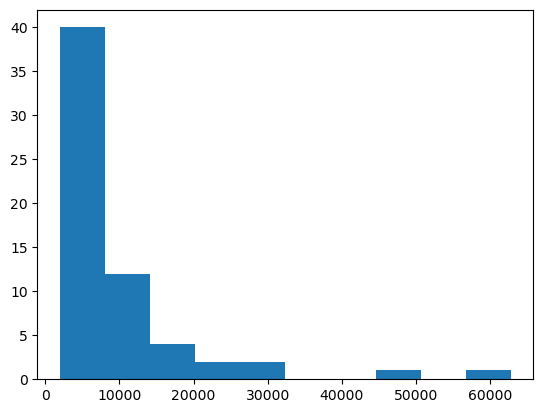

count    57.000000
mean     22.140351
std      14.575467
min       4.000000
25%      13.000000
50%      18.000000
75%      24.000000
max      68.000000
Name: age, dtype: float64


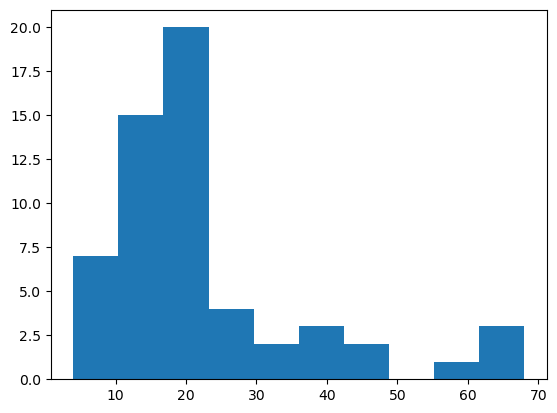

In [5]:
print(df['price'].describe())
df['price'].hist(grid=False)
plt.show()
print(df['age'].describe())
df['age'].hist(grid=False)
plt.show()

In [6]:
# Price by brand:
df.loc[:,['price','brand']].groupby('brand').describe()

price                                                         \
           count          mean           std      min      25%      50%   
brand                                                                     
acura        2.0   5250.000000   3181.980515   3000.0   4125.0   5250.0   
audi         1.0  11000.000000           NaN  11000.0  11000.0  11000.0   
bmw          2.0   8750.000000   1767.766953   7500.0   8125.0   8750.0   
cadillac     1.0   2950.000000           NaN   2950.0   2950.0   2950.0   
chevrolet    2.0   9750.000000   6717.514421   5000.0   7375.0   9750.0   
chevy        3.0   3966.666667   1761.628035   2900.0   2950.0   3000.0   
dodge        2.0   6875.000000   4065.863992   4000.0   5437.5   6875.0   
ford         7.0  17142.857143  15258.096992   4000.0   8250.0  13500.0   
gmc          2.0  16500.000000  13435.028843   7000.0  11750.0  16500.0   
honda       10.0   9020.000000   8044.017791   2800.0   3725.0   6200.0   
jeep         3.0   7900.000000   1429.160593   6250.0   7475.0   8700.0   
kia          1.0   2500.000000           NaN   2500.0   2500.0   2500.0   
lexus        2.0  11175.000000    318.198052  10950.0  11062.5  11175.0   
missing     15.0   8759.933333  15883.759723   2000.0   3050.0   3500.0   
mitsubishi   1.0   6800.000000           NaN   6800.0   6800.0   6800.0   
tesla        1.0  26900.000000           NaN  26900.0  26900.0  26900.0   
toyota       5.0   8280.000000   5147.523676   3000.0   5200.0   6500.0   
volkswagen   2.0   4550.000000   2757.716447   2600.0   3575.0   4550.0   

                              
                75%      max  
brand                         
acura        6375.0   7500.0  
audi        11000.0  11000.0  
bmw          9375.0  10000.0  
cadillac     2950.0   2950.0  
chevrolet   12125.0  14500.0  
chevy        4500.0   6000.0  
dodge        8312.5   9750.0  
ford        18250.0  49500.0  
gmc         21250.0  26000.0  
honda       11725.0  29000.0  
jeep         8725.0   8750.0  
kia          2500.0   2500.0  
lexus       11287.5  11400.0  
missing      4499.5  62800.0  
mitsubishi   6800.0   6800.0  
tesla       26900.0  26900.0  
toyota      10700.0  16000.0  
volkswagen   5525.0   6500.0

In [7]:
# Age by brand:
df.loc[:,['age','brand']].groupby('brand').describe()

age                                                      
           count       mean        std   min    25%   50%    75%   max
brand                                                                 
acura        2.0  15.000000   5.656854  11.0  13.00  15.0  17.00  19.0
audi         1.0   8.000000        NaN   8.0   8.00   8.0   8.00   8.0
bmw          2.0  16.500000   0.707107  16.0  16.25  16.5  16.75  17.0
cadillac     1.0  19.000000        NaN  19.0  19.00  19.0  19.00  19.0
chevrolet    2.0  47.500000  16.263456  36.0  41.75  47.5  53.25  59.0
chevy        1.0  21.000000        NaN  21.0  21.00  21.0  21.00  21.0
dodge        2.0  26.500000   6.363961  22.0  24.25  26.5  28.75  31.0
ford         7.0  18.000000   8.485281   8.0  12.00  17.0  22.00  33.0
gmc          1.0  41.000000        NaN  41.0  41.00  41.0  41.00  41.0
honda       10.0  14.100000   6.471304   4.0  11.25  14.0  15.75  28.0
jeep         3.0  14.333333   3.214550  12.0  12.50  13.0  15.50  18.0
kia          1.0  17.000000        NaN  17.0  17.00  17.0  17.00  17.0
lexus        2.0  17.000000   5.656854  13.0  15.00  17.0  19.00  21.0
missing     13.0  31.923077  21.398838   7.0  18.00  24.0  46.00  68.0
mitsubishi   1.0  17.000000        NaN  17.0  17.00  17.0  17.00  17.0
tesla        1.0   7.000000        NaN   7.0   7.00   7.0   7.00   7.0
toyota       5.0  19.200000   4.919350  12.0  17.00  21.0  21.00  25.0
volkswagen   2.0  33.000000  15.556349  22.0  27.50  33.0  38.50  44.0

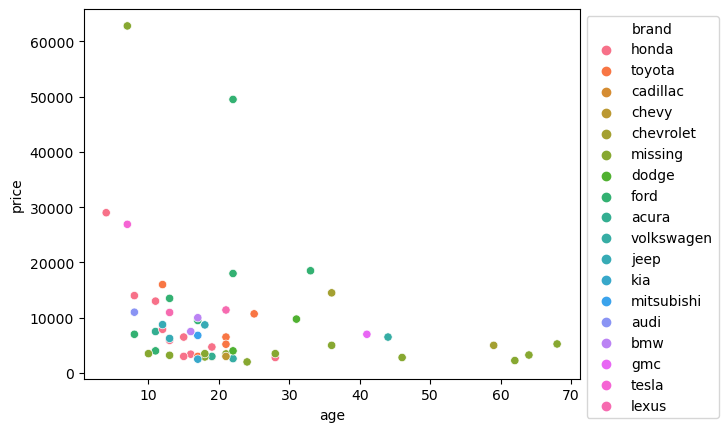

In [8]:
ax = sns.scatterplot(data=df, x='age', y='price',hue='brand')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

           log_price   log_age
log_price   0.626000 -0.181308
log_age    -0.181308  0.345214
           log_price   log_age
log_price   1.000000 -0.397748
log_age    -0.397748  1.000000


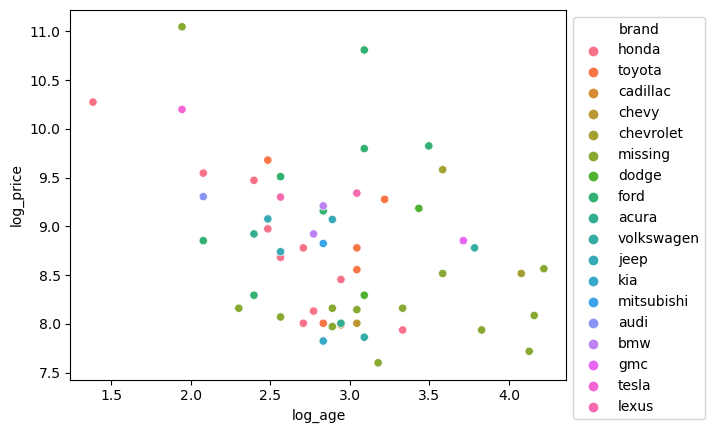

In [9]:
df['log_price'] = np.log(df['price'])
df['log_age'] = np.log(df['age'])

ax = sns.scatterplot(data=df, x='log_age', y='log_price',hue='brand')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

print(df.loc[:,['log_price','log_age']].cov())
print(df.loc[:,['log_price','log_age']].corr())

## The Lab:


1. Pick something else on Craigslist besides used cars: Musical instruments, roommates, antiques, etc. Look at the search page and its source code. Record which fields/data you would like to gather, and what kinds of basic EDA you'd do with it.
2. Get your search results of interest using `requests` and extract data from them using `beautifulSoup`, using code similar to what's above.
3. Wrangle your data into a dataframe and do some basic descriptions and plots. Try to find some interesting relationships or stories to tell about your data.

In [10]:
# setting up environment: fetching data from music-instr pages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import requests

header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0'}
url = 'https://charlottesville.craigslist.org/search/msa#search=1~gallery~0~9'
raw = requests.get(url, headers = header)


I will fetch data from the music-instr page. I'm just curious to see what type of instruments will be available, as well as their prices compared to traditional market value. I'm mostly interested in seeing what's available and seeing whether the most popular or common items are actual instruments or accessories.

In [11]:
from bs4 import BeautifulSoup as soup
bs0bj = soup(raw.content, 'html.parser')
listings = bs0bj.find_all(class_ = "cl-static-search-result")

In [37]:
import re

brands_guitar = ['Fender', 'Gretsch', 'epiphone', 'jackson', 'rickenbacker',
                 'g&l musical instruments', 'ovation guitar company', 'charvel', 
                 'ibanez', 'yamaha', 'c.f. martin & company', 'esp', 'schecter', 
                 'godin', 'takamine', 'cort guitars', 'gibson', 'prs', 'taylor',
                 'seagull', 'music man', 'alvarez guitars', 'kramer', 'geeny', 'martin',
                 'evh']
                 

data_guitar = [] # We'll save our listings in this object
for k in range( len(listings) ):
    title = listings[k].find('div',class_='title').get_text().lower()
    price = listings[k].find('div',class_='price').get_text()
    link = listings[k].find(href=True)['href']
    # Get brand from the title string:
    words = title.split()
    hits = [word for word in words if word in brands_guitar] # Find brands in the title
    if len(hits) == 0:
        brand = 'missing'
    else:
        brand = hits[0]
    # Get years from title string:
    regex_search = re.search(r'20[0-9][0-9]|19[0-9][0-9]', title ) # Find year references
    if regex_search is None: # If no hits, record year as missing value
        year = np.nan
    else: # If hits, record year as first match
        year = regex_search.group(0)
    #
    data_guitar.append({'title':title,'price':price,'year':year,'link':link,'brand':brand})




In [38]:
# wrangling/converting to readable df

df_guitar = pd.DataFrame.from_dict(data_guitar)
df_guitar['price'] = df_guitar['price'].str.replace('$','')
df_guitar['price'] = df_guitar['price'].str.replace(',','')
df_guitar['price'] = pd.to_numeric(df_guitar['price'],errors='coerce')
df_guitar['year'] = pd.to_numeric(df_guitar['year'],errors='coerce')
df_guitar['age'] = 2025-df_guitar['year']
print(df_guitar.shape)
df_guitar.to_csv('./src/craigslist_cville_music_instr.csv') # Save data in case of a disaster
df_guitar.head(20)

(126, 6)


,title,price,year,link,brand,age
0,1970s left-handed 5-string banjo,375,1970.0,https://charlottesville.craigslist.org/msg/d/c...,missing,55.0
1,"new casematix 16"" hard travel case",40,NaN,https://charlottesville.craigslist.org/msg/d/c...,missing,NaN
2,esp ltd m-1000 ebony,750,NaN,https://charlottesville.craigslist.org/msg/d/c...,esp,NaN
3,gibson les paul faded (2018),900,2018.0,https://charlottesville.craigslist.org/msg/d/c...,gibson,7.0
4,hand pan hang drum symphonic steel,2500,NaN,https://charlottesville.craigslist.org/msg/d/c...,missing,NaN
5,"esp edwards alexi laiho ""geeny""",1400,NaN,https://charlottesville.craigslist.org/msg/d/c...,esp,NaN
6,guitar maintenance accessories assortment,30,NaN,https://charlottesville.craigslist.org/msg/d/c...,missing,NaN
7,ampeg ba-108 bass amp (20 watts),75,NaN,https://charlottesville.craigslist.org/msg/d/c...,missing,NaN
8,"slide guitar package (instructionals, slides, ...",40,NaN,https://charlottesville.craigslist.org/msg/d/c...,missing,NaN
9,martin d35 sunburst with fishman pickup,2800,NaN,https://charlottesville.craigslist.org/msg/d/c...,martin,NaN


count     126.000000
mean      452.690476
std       701.049732
min         0.000000
25%        50.000000
50%       175.000000
75%       600.000000
max      5000.000000
Name: price, dtype: float64


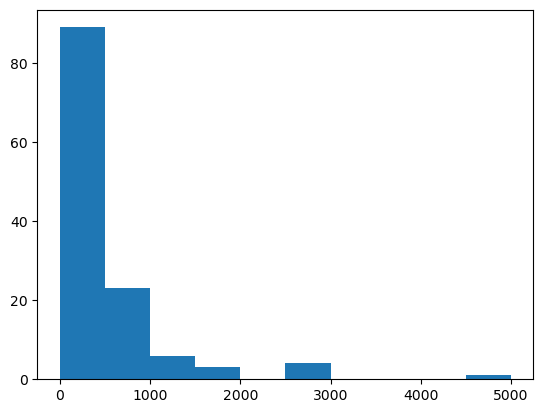

In [39]:
# brief analysis: price plot
print(df_guitar['price'].describe())
df_guitar['price'].hist(grid = False)
plt.show()

count    16.000000
mean     37.875000
std      14.836329
min       7.000000
25%      28.750000
50%      43.500000
75%      49.000000
max      55.000000
Name: age, dtype: float64


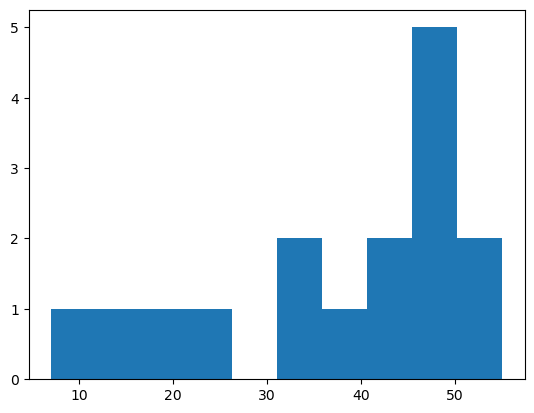

In [40]:
print(df_guitar['age'].describe())
df_guitar['age'].hist(grid = False)
plt.show()

In [41]:
# listing the different brands and respective price - quick summary
df_guitar.loc[:, ['price', 'brand']].groupby('brand').describe()

price                                                            \
          count         mean          std    min      25%     50%     75%   
brand                                                                       
epiphone    1.0   500.000000          NaN  500.0   500.00   500.0   500.0   
esp         2.0  1075.000000   459.619408  750.0   912.50  1075.0  1237.5   
evh         1.0   600.000000          NaN  600.0   600.00   600.0   600.0   
gibson      5.0   543.000000   455.653377   40.0    50.00   825.0   900.0   
ibanez      2.0   225.000000    70.710678  175.0   200.00   225.0   250.0   
martin      4.0   923.750000  1253.630561  195.0   273.75   350.0  1000.0   
missing   106.0   408.764151   698.004033    0.0    50.00   150.0   475.0   
taylor      2.0  1425.000000   671.751442  950.0  1187.50  1425.0  1662.5   
yamaha      3.0   250.000000    86.602540  150.0   225.00   300.0   300.0   

                  
             max  
brand             
epiphone   500.0  
esp       1400.0  
evh        600.0  
gibson     900.0  
ibanez     275.0  
martin    2800.0  
missing   5000.0  
taylor    1900.0  
yamaha     300.0

In [42]:
# looking at age by brand
df_guitar.loc[:,['age','brand']].groupby('brand').describe()

age                                                
         count  mean       std   min    25%   50%    75%   max
brand                                                         
epiphone   1.0  16.0       NaN  16.0  16.00  16.0  16.00  16.0
esp        0.0   NaN       NaN   NaN    NaN   NaN    NaN   NaN
evh        0.0   NaN       NaN   NaN    NaN   NaN    NaN   NaN
gibson     2.0  12.5  7.778175   7.0   9.75  12.5  15.25  18.0
ibanez     1.0  43.0       NaN  43.0  43.00  43.0  43.00  43.0
martin     0.0   NaN       NaN   NaN    NaN   NaN    NaN   NaN
missing   12.0  43.5  9.858084  22.0  38.00  47.5  49.25  55.0
taylor     0.0   NaN       NaN   NaN    NaN   NaN    NaN   NaN
yamaha     0.0   NaN       NaN   NaN    NaN   NaN    NaN   NaN

In [43]:
# taking a look at the values listed for age
print(df_guitar['price'].unique())

[ 375   40  750  900 2500 1400   30   75 2800   25  200  350  300   80
   21    1 5000  600  250  400   20   35   50  150 1200  160  175  650
   65  155  850  125  575    0  275  825 1900 1300  225  110  165 1000
 1695    5   15  950  299  700  675  100  260  399    8   85   99  829
 1100  795  500  800   10   90 1250  195 1800]


In [44]:
# looking at values for age:
print(df_guitar['age'].unique())

[55. nan  7. 35. 43. 48. 53. 50. 49. 47. 44. 18. 31. 39. 16. 22.]


Lots of missing values with these entries.

In [45]:
# looking at values listed in brands: only 6 recorded
print(df_guitar['brand'].unique())

['missing' 'esp' 'gibson' 'martin' 'yamaha' 'evh' 'ibanez' 'taylor'
 'epiphone']


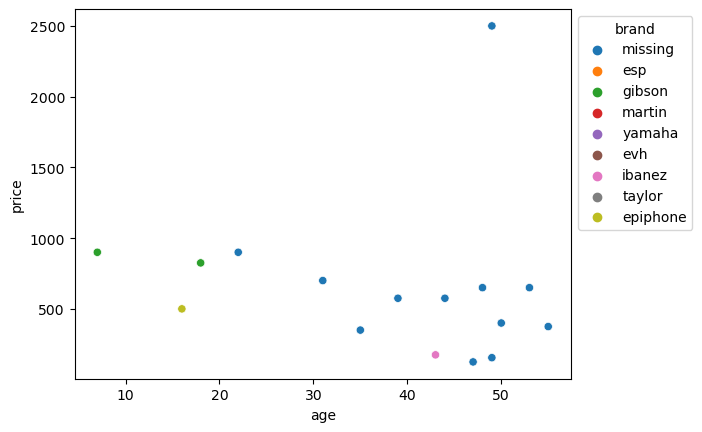

In [46]:
# scatter by age x price

ax = sns.scatterplot(data = df_guitar, x = 'age', y = 'price', hue = 'brand')
sns.move_legend(ax, "upper left", bbox_to_anchor = (1, 1))

Most of the points plotted have brands missing. The majority of the data points fall within the 40 - 50 age range and seem to be lower in price.

           log_price   log_age
log_price   3.019282 -0.136177
log_age    -0.136177  0.325119
           log_price   log_age
log_price   1.000000 -0.317687
log_age    -0.317687  1.000000


/Users/yuthimadireddy/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


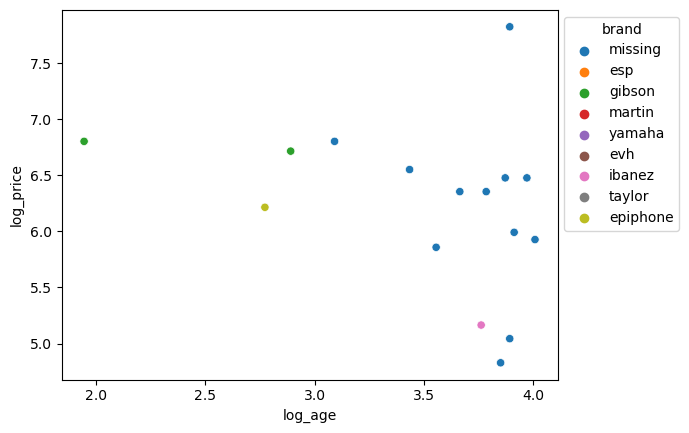

In [47]:
df_guitar['log_price'] = np.log(df_guitar['price'])
df_guitar['log_age'] = np.log(df_guitar['age'])

ax = sns.scatterplot(data=df_guitar, x='log_age', y='log_price',hue='brand')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

print(df_guitar.loc[:,['log_price','log_age']].cov())
print(df_guitar.loc[:,['log_price','log_age']].corr())

Based on some brief stat summaries/plots, it seems that there are many missing values regarding many information about age for this category. Additionally, a lot of the product descriptions didn't seem to transfer into the 'brand' extraction. For instruments, many of the title descriptions are either too specific or not specific enough. There is such a wide myriad of different product titles that none of them overlap. Of course, the price column seems to not have any missing values since the whole point of Craigslist is to sell items, though it is interesting to see the extent of the lack of information available for many of the products offered. The data in the 'age' column seems to be quite spread out.

The main issue I see however, is the lack of brands recorded when extracting the data. There were many more brands listed in Craigslist, but I don't think I listed them all when defining guitar_brands and as a result only a few records matching those were able to be extracted. There is a large discrepancy in not only the amount of records but also the values within the records, which has resulted in a lot of 'missing' and NaN values in the dataset. A lot of the descriptions of the products mentioned how the products were pretty old and the owner wanted to pass them along.